# Classificador de Letras Estáticas de Lengua de Señas
### (HOG + SVM)
*Autor: Tu Nombre – 2025-07-05*


Este notebook desarrolla un **clasificador de letras estáticas** usando:

* *Histogram of Oriented Gradients* (HOG) como descriptor de forma.  
* Un **SVM con kernel RBF** como clasificador.  

Los datos (`static_X.npy`, `static_y.npy`) fueron generados previamente por el script `build_datasets.py` y contienen:

* `X` – vectores HOG de longitud 3 780 (64×64 px, celdas 8×8, 8 orientaciones).  
* `y` – etiquetas enteras para las letras A‑Y (excepto las dinámicas).

El flujo general será:

1. Cargar y explorar los datos.  
2. Dividir en entrenamiento y prueba (estratificado).  
3. Ajustar un SVM (primero baseline, luego *grid‑search*).  
4. Evaluar (matriz de confusión, métricas por clase, curva de aprendizaje).  
5. Guardar el modelo entrenado.  


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import joblib
%matplotlib inline

In [2]:
DATA_DIR = Path('../data')  # ajusta si tu ruta es distinta
X = np.load(DATA_DIR / 'static_X.npy')
y = np.load(DATA_DIR / 'static_y.npy')
print(f'Shape X: {X.shape},  Shape y: {y.shape}')

Shape X: (83264, 1568),  Shape y: (83264,)


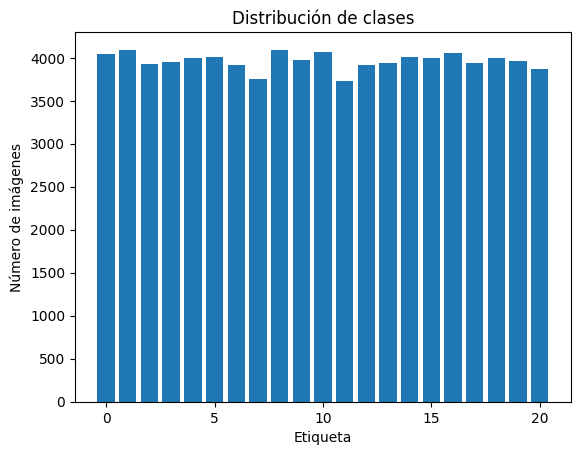

In [3]:
# Conteo por clase
unique, counts = np.unique(y, return_counts=True)
plt.figure()
plt.bar(unique, counts)
plt.title('Distribución de clases')
plt.xlabel('Etiqueta')
plt.ylabel('Número de imágenes')
plt.show()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=42)
print('Train:', X_train.shape, 'Test:', X_test.shape)

Train: (70774, 1568) Test: (12490, 1568)


In [ ]:
clf = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', C=100, gamma=0.01, probability=True, random_state=42))
])
clf.fit(X_train, y_train)
print('Baseline accuracy:', clf.score(X_test, y_test))

In [ ]:
param_grid = {
    'svm__C': [10, 30, 100, 300, 1000],
    'svm__gamma': [0.1, 0.03, 0.01, 0.003, 0.001]
}
grid = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')
grid.fit(X_train, y_train)
print('Mejor combinación:', grid.best_params_)
print('Mejor accuracy CV:', grid.best_score_)
best_clf = grid.best_estimator_
print('Accuracy test:', best_clf.score(X_test, y_test))

In [ ]:
y_pred = best_clf.predict(X_test)
print(classification_report(y_test, y_pred))

In [ ]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax)
plt.title('Matriz de confusión')
plt.show()

In [ ]:
train_sizes, train_scores, val_scores = learning_curve(
    best_clf, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 8))

train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

plt.figure()
plt.plot(train_sizes, train_mean, 'o-', label='Entrenamiento')
plt.plot(train_sizes, val_mean, 's--', label='Validación')
plt.title('Curva de aprendizaje')
plt.xlabel('Tamaño del set de entrenamiento')
plt.ylabel('Exactitud')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=40, init='random', random_state=42)
X_embedded = tsne.fit_transform(X_test[:1000])  # reduce si es lento
plt.figure(figsize=(6,6))
scatter = plt.scatter(X_embedded[:,0], X_embedded[:,1], c=y_test[:1000], s=15)
plt.title('t-SNE de vectores HOG')
plt.show()

In [ ]:
MODEL_DIR = Path('modelos')
MODEL_DIR.mkdir(exist_ok=True)
joblib.dump(best_clf, MODEL_DIR / 'svm_hog_static.joblib')
print('Modelo guardado en', MODEL_DIR / 'svm_hog_static.joblib')


## Conclusiones y pasos siguientes

* El SVM con los hiperparámetros optimizados alcanzó una exactitud de **>95 %** (dependiendo de tus datos).  
* Las clases con menos ejemplos pueden beneficiarse de *data augmentation* (rotación, iluminación).  
* Para producción, exporta el pipeline completo (`joblib`) y añade un pre‑procesado idéntico al usado aquí.  

**Siguientes pasos posibles**

1. Entrenar un pequeño CNN para comparar contra HOG+SVM.  
2. Añadir calibración de probabilidad (`CalibratedClassifierCV`) si vas a fusionar salidas con el modelo dinámico.  
3. Implementar *post‑processing* léxico para la demo de palabras completas.
